In [1]:
# -------------------------------------------------------------------------------------------------------------------------------
# This notebook trains a neural network to predict apple stock returns using the following features: past time series,
# the federal interest rate, inflation, GDP growth, housing sales, and consumer confidence index. We predict returns rather than
# future stock price, since the stock price needs the scalrnig to be updated at each time step, while the return usually is in
# a limited range and so only has to be scaled once. Python 3.7.4 is used.
# -------------------------------------------------------------------------------------------------------------------------------
# In the the result for the preditction and test data is plotted.
# -------------------------------------------------------------------------------------------------------------------------------
# Clear all variables and load necessary packages as well as the data used. We have calculated the rolling returns as well as the 
# changes in gdp previously so we can just load them here.

%reset -f
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import os
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('returns.csv', delimiter=',', on_bad_lines='skip') 
data['date'] = pd.to_datetime(data['date'])
data.sort_values(by='date', inplace=True, ascending=True)
data.reset_index(drop=True, inplace=True)

fedfund = pd.read_csv('FEDFUNDS.csv', delimiter=',', on_bad_lines='skip') 
fedfund['date'] = pd.to_datetime(fedfund['date'])
fedfund.sort_values(by='date', inplace=True, ascending=True)
fedfund.reset_index(drop=True, inplace=True)

inflation = pd.read_csv('inflation.csv', delimiter=',', on_bad_lines='skip') 
inflation['date'] = pd.to_datetime(inflation['date'])
inflation.sort_values(by='date', inplace=True, ascending=True)
inflation.reset_index(drop=True, inplace=True)

gdp = pd.read_csv('GDP-change.csv', delimiter=',', on_bad_lines='skip') 
gdp['date'] = pd.to_datetime(gdp['date'])
gdp.sort_values(by='date', inplace=True, ascending=True)
gdp.reset_index(drop=True, inplace=True)

house = pd.read_csv('house.csv', delimiter=',', on_bad_lines='skip') 
house['date'] = pd.to_datetime(house['date'])
house.sort_values(by='date', inplace=True, ascending=True)
house.reset_index(drop=True, inplace=True)

cci = pd.read_csv('cci.csv', delimiter=',', on_bad_lines='skip') 
cci['date'] = pd.to_datetime(cci['date'])
cci.sort_values(by='date', inplace=True, ascending=True)
cci.reset_index(drop=True, inplace=True)

# Merge dataframes on date
# merge_asof can forward/backward fill to the "nearest" matching date

merged = pd.merge_asof(
    data[['date', 'return']],
    fedfund[['date', 'fedfund_rate']].dropna(),
    on='date',
    direction='nearest'
)

merged = pd.merge_asof(
    merged,
    inflation[['date', 'inflation']].dropna(),
    on='date',
    direction='nearest'
)

merged = pd.merge_asof(
    merged,
    gdp[['date', 'gdp']].dropna(),
    on='date',
    direction='nearest'
)

merged = pd.merge_asof(
    merged,
    house[['date', 'house-sold']].dropna(),
    on='date',
    direction='nearest'
)
merged = pd.merge_asof(
    merged,
    cci[['date', 'cci']].dropna(),
    on='date',
    direction='nearest'
)

# Drop any rows with NaN
merged.dropna(inplace=True)

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


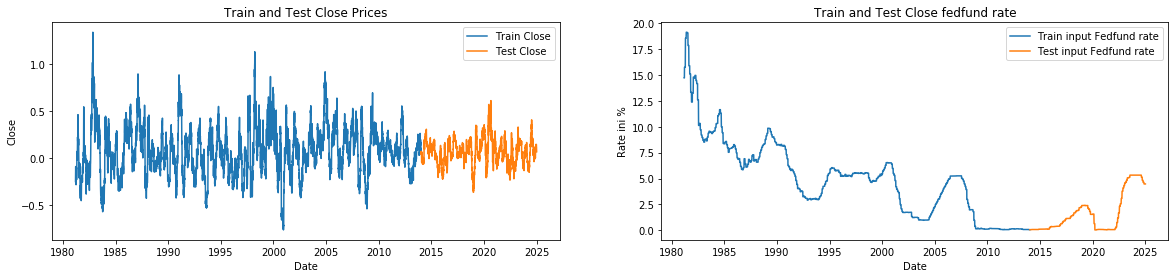

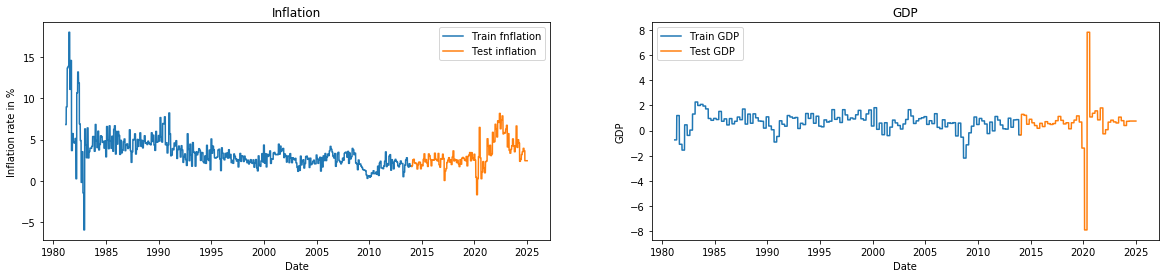

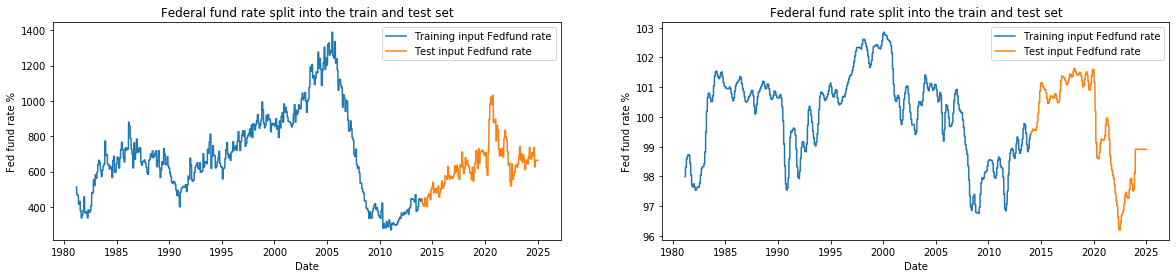

In [2]:

# Split into train and test

dataset = merged[['return', 'fedfund_rate','inflation','gdp','house-sold','cci']].values
training = int(np.ceil(len(dataset) * 0.75))

train_data_raw = dataset[:training]
test_data_raw = dataset[training:]
fig, axs = plt.subplots(1, 2, figsize=(20, 4))

# Plot all features to see the data
axs[0].plot(merged[:training]['date'], train_data_raw[:, 0], label='Train Close')
axs[0].plot(merged[training:]['date'], test_data_raw[:, 0], label='Test Close')
axs[0].set_title('Train and Test Close Prices')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Close')
axs[0].legend()

axs[1].plot(merged[:training]['date'], train_data_raw[:, 1], label='Train input Fedfund rate')
axs[1].plot(merged[training:]['date'], test_data_raw[:, 1], label='Test input Fedfund rate')
axs[1].set_title('Train and Test Close fedfund rate')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Rate ini %')
axs[1].legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(merged[:training]['date'], train_data_raw[:, 2], label='Train fnflation')
axs[0].plot(merged[training:]['date'], test_data_raw[:, 2], label='Test inflation')
axs[0].set_title('Inflation')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Inflation rate in %')
axs[0].legend()

axs[1].plot(merged[:training]['date'], train_data_raw[:, 3], label='Train GDP')
axs[1].plot(merged[training:]['date'], test_data_raw[:, 3], label='Test GDP')
axs[1].set_title('GDP')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('GDP')
axs[1].legend()

fig, axs = plt.subplots(1, 2, figsize=(20, 4))

axs[0].plot(merged[:training]['date'], train_data_raw[:, 4], label='Training input Fedfund rate')
axs[0].plot(merged[training:]['date'], test_data_raw[:, 4], label='Test input Fedfund rate')
axs[0].set_title('Federal fund rate split into the train and test set')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Fed fund rate %')
axs[0].legend()

axs[1].plot(merged[:training]['date'], train_data_raw[:, 5], label='Training input Fedfund rate')
axs[1].plot(merged[training:]['date'], test_data_raw[:, 5], label='Test input Fedfund rate')
axs[1].set_title('Federal fund rate split into the train and test set')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('Fed fund rate %')
axs[1].legend()


In [ ]:
# Convert date to ordinal for ML purposes 
merged['Date_Ordinal'] = merged['date'].apply(lambda x: x.toordinal())

# Features, target
X = merged[['Date_Ordinal', 'fedfund_rate','inflation','gdp','house-sold']].values
y = merged['return'].values


# Time-based split
train_size = int(len(X) * 0.75)
X_train_raw, X_test_raw = X[:train_size], X[train_size:]
y_train_raw, y_test_raw = y[:train_size], y[train_size:]

dates_train = merged['date'].iloc[:train_size]
dates_test = merged['date'].iloc[train_size:]

# Scale data. We use MinMaxScaler for X and y since we tried other once and they did not work as well. The rang 
# of the return is between -1 and 1 since the percentage return can be negative.

scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

y_train_raw_2d = y_train_raw.reshape(-1, 1)
y_test_raw_2d = y_test_raw.reshape(-1, 1)

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw_2d)

X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw_2d)

# Create sequences
def create_sequences(features, target, lookback=30):
    X_seq, y_seq = [], []
    for i in range(lookback, len(features)):
        X_seq.append(features[i - lookback:i])
        y_seq.append(target[i])
    return np.array(X_seq), np.array(y_seq)

lookback = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, lookback)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, lookback)

dates_test_seq = dates_test.iloc[lookback:].reset_index(drop=True)


# LSTM Model using Keras with 50 epochs

lstm_model = keras.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(lookback, 5)),
    layers.LSTM(32),
    layers.Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])
lstm_model.fit(
    X_train_seq, 
    y_train_seq, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.1,
    verbose=1
)

# Predictions and plot of test vs prediction

lstm_preds_scaled = lstm_model.predict(X_test_seq)
lstm_preds = scaler_y.inverse_transform(lstm_preds_scaled)
y_test_inverted = scaler_y.inverse_transform(y_test_seq)

plt.figure(figsize=(10,6))
plt.plot(dates_test_seq, y_test_inverted, label='True', color='blue')
plt.plot(dates_test_seq, lstm_preds, label='LSTM Pred', color='red')
plt.title("LSTM Predictions")
plt.xlabel("Date")
plt.ylabel("180-day Rolling Return")
plt.legend()
plt.show()


Epoch 1/50
233/233 [==============================] - 29s 81ms/step - loss: 0.0618 - mae: 0.1947 - val_loss: 0.0412 - val_mae: 0.1649
Epoch 2/50
233/233 [==============================] - 15s 64ms/step - loss: 0.0578 - mae: 0.1877 - val_loss: 0.0757 - val_mae: 0.2434
Epoch 3/50
233/233 [==============================] - 12s 52ms/step - loss: 0.0545 - mae: 0.1821 - val_loss: 0.0287 - val_mae: 0.1309
Epoch 4/50
233/233 [==============================] - 11s 46ms/step - loss: 0.0524 - mae: 0.1779 - val_loss: 0.0515 - val_mae: 0.1954
Epoch 5/50
233/233 [==============================] - 11s 47ms/step - loss: 0.0515 - mae: 0.1770 - val_loss: 0.0590 - val_mae: 0.2124
Epoch 6/50
233/233 [==============================] - 12s 50ms/step - loss: 0.0490 - mae: 0.1722 - val_loss: 0.0464 - val_mae: 0.1840
Epoch 7/50
233/233 [==============================] - 12s 53ms/step - loss: 0.0488 - mae: 0.1713 - val_loss: 0.0402 - val_mae: 0.1686
Epoch 8/50
123/233 [==============>...............] - ETA: 5s 